# Train Binary Model

## OG Data

In [1]:
#Based on examples from the Keras documentation
import numpy as np
np.random.seed(42)
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

num_classes = 6
input_shape = (136, 136, 1)

with open("/share/jcorner_data/pkls/1996_2011_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/pkls/2012_2013_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/pkls/2014_2017_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (4560, 136, 136, 1)
4560 train samples
309 validate samples
920 test samples


In [2]:
types = ['test', 'train', 'val']

#
for type in types:
    image_data = []
    image_label = []
    
    #
    for i in range(len(locals()[f'y_{type}'])):
    
        #
        if locals()[f'y_{type}'][i][0] == 1 or locals()[f'y_{type}'][i][4] == 1:
            image_data.append(locals()[f'x_{type}'][i,:,:,:])
            
            #
            if locals()[f'y_{type}'][i][0] == 1:
                image_label.append([1., 0.])
    
            #
            elif  locals()[f'y_{type}'][i][4] == 1:
                image_label.append([0., 1.])
    
    #
    locals()[f'x_{type}_bin'] = np.array(image_data)
    locals()[f'y_{type}_bin'] = np.array(image_label)

In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Dense(16, activation="relu"),
        layers.Flatten(),
        layers.Dense(2, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 132, 132, 32)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 average_pooling2d (AverageP  (None, 64, 64, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       204928    
                                                                 
 average_pooling2d_1 (Averag  (None, 30, 30, 128)      0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 30, 30, 16)        2

2023-09-17 19:20:37.422306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-17 19:20:37.430501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-17 19:20:37.430650: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-17 19:20:37.431228: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate 

In [4]:
datagen = ImageDataGenerator(rotation_range=55, zoom_range=[0.9,1.0], fill_mode="reflect")

In [5]:
epochs = 10

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train_bin, y_train_bin, batch_size=32), epochs=epochs, validation_data=(x_val_bin, y_val_bin), workers=8)

Epoch 1/10


2023-09-17 19:20:48.995257: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8500
2023-09-17 19:20:49.470632: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


35/35 [==============================] - 5s 62ms/step - loss: 0.2193 - accuracy: 0.8731 - val_loss: 0.0300 - val_accuracy: 0.9918
Epoch 2/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0470 - accuracy: 0.9854 - val_loss: 0.0210 - val_accuracy: 0.9918
Epoch 3/10
35/35 [==============================] - 2s 48ms/step - loss: 0.0418 - accuracy: 0.9845 - val_loss: 0.0628 - val_accuracy: 0.9918
Epoch 4/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0935 - accuracy: 0.9708 - val_loss: 0.0223 - val_accuracy: 1.0000
Epoch 5/10
35/35 [==============================] - 2s 43ms/step - loss: 0.0279 - accuracy: 0.9918 - val_loss: 0.0197 - val_accuracy: 0.9836
Epoch 6/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0205 - val_accuracy: 0.9836
Epoch 7/10
35/35 [==============================] - 2s 44ms/step - loss: 0.0222 - accuracy: 0.9936 - val_loss: 0.0413 - val_accuracy: 0.9836
Epoch 8/10
35/35 [======

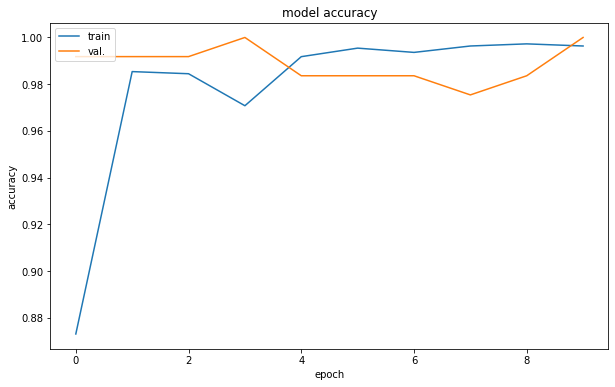

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

In [7]:
score = model.evaluate(x_test_bin, y_test_bin, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.013886538334190845
Test accuracy: 0.9930434823036194


In [8]:
#save the model
#model.save("/share/jcorner_data/models/Two_Class_model_v01.h5")

## Top Class Data

In [1]:
#Based on examples from the Keras documentation
import numpy as np
np.random.seed(42)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle

num_classes = 5
input_shape = (136, 136, 1)

with open("/share/jcorner_data/gridrad/nexrad/nexradv2/2007_2014_train.pkl", "rb") as f:
    (x_train, y_train) = pickle.load(f)

with open("/share/jcorner_data/gridrad/nexrad/nexradv2/2015_2015_validation.pkl", "rb") as f:
    (x_val, y_val) = pickle.load(f)

with open("/share/jcorner_data/gridrad/nexrad/nexradv2/2016_2017_test.pkl", "rb") as f:
    (x_test, y_test) = pickle.load(f)

#Normalize by 80 dBZ
x_train = x_train.astype("float32") / 80
x_test = x_test.astype("float32") / 80
x_val = x_val.astype("float32") / 80

print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_val.shape[0], "validate samples")
print(x_test.shape[0], "test samples")

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)



x_train shape: (3364, 136, 136, 1)
3364 train samples
277 validate samples
463 test samples


In [2]:
types = ['test', 'train', 'val']

#
for type in types:
    image_data = []
    image_label = []
    
    #
    for i in range(len(locals()[f'y_{type}'])):
    
        #
        if locals()[f'y_{type}'][i][1] == 1 or locals()[f'y_{type}'][i][3] == 1:
            image_data.append(locals()[f'x_{type}'][i,:,:,:])
            
            #
            if locals()[f'y_{type}'][i][1] == 1:
                image_label.append([1., 0.])
    
            #
            elif  locals()[f'y_{type}'][i][3] == 1:
                image_label.append([0., 1.])
    
    #
    locals()[f'x_{type}_bin'] = np.array(image_data)
    locals()[f'y_{type}_bin'] = np.array(image_label)

In [3]:
model = keras.Sequential(
    [
        keras.Input(shape=(136, 136, 1)),
        layers.Conv2D(32, kernel_size=(5, 5), activation="relu"),
        layers.Conv2D(64, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(5, 5), activation="relu"),
        layers.AveragePooling2D(pool_size=(2, 2)),
        layers.Dense(32, activation="relu"),
        layers.Flatten(),
        layers.Dense(2, activation="softmax"),
    ]
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 132, 132, 32)      832       
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      51264     
                                                                 
 average_pooling2d (AverageP  (None, 64, 64, 64)       0         
 ooling2D)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       204928    
                                                                 
 average_pooling2d_1 (Averag  (None, 30, 30, 128)      0         
 ePooling2D)                                                     
                                                                 
 dense (Dense)               (None, 30, 30, 32)        4

2023-09-18 02:05:05.246319: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 02:05:05.253808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 02:05:05.253978: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:952] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-09-18 02:05:05.254713: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate 

In [4]:
datagen = ImageDataGenerator(zoom_range=[0.9,1.0], fill_mode="reflect")

In [5]:
epochs = 7

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = model.fit(datagen.flow(x_train_bin, y_train_bin, batch_size=64), epochs=epochs, validation_data=(x_val_bin, y_val_bin), workers=8)

Epoch 1/7


2023-09-18 02:05:08.191459: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8500
2023-09-18 02:05:08.684762: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


33/33 [==============================] - 6s 107ms/step - loss: 0.4317 - accuracy: 0.7905 - val_loss: 0.3238 - val_accuracy: 0.8955
Epoch 2/7
33/33 [==============================] - 3s 75ms/step - loss: 0.3461 - accuracy: 0.8466 - val_loss: 0.2467 - val_accuracy: 0.9303
Epoch 3/7
33/33 [==============================] - 3s 75ms/step - loss: 0.3011 - accuracy: 0.8675 - val_loss: 0.2178 - val_accuracy: 0.9254
Epoch 4/7
33/33 [==============================] - 3s 78ms/step - loss: 0.2625 - accuracy: 0.8808 - val_loss: 0.2374 - val_accuracy: 0.9154
Epoch 5/7
33/33 [==============================] - 3s 72ms/step - loss: 0.2368 - accuracy: 0.9078 - val_loss: 0.2864 - val_accuracy: 0.8607
Epoch 6/7
33/33 [==============================] - 3s 74ms/step - loss: 0.1972 - accuracy: 0.9173 - val_loss: 0.1821 - val_accuracy: 0.9303
Epoch 7/7
33/33 [==============================] - 3s 78ms/step - loss: 0.2307 - accuracy: 0.9059 - val_loss: 0.1901 - val_accuracy: 0.9303


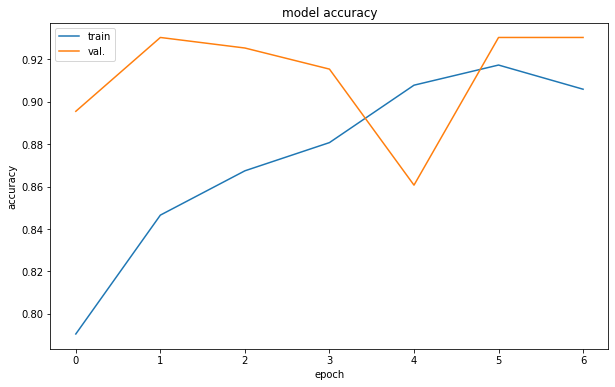

In [6]:
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10, 6

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val.'], loc='upper left')
plt.show()

In [7]:
score = model.evaluate(x_test_bin, y_test_bin, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.23894822597503662
Test accuracy: 0.9006849527359009


In [8]:
#save the model
#model.save("/share/jcorner_data/models/Two_Class_model_v2.h5")